In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow.keras as tk
import numpy as np
import pandas as pd
import os
import datetime
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
#from chexpert_parser import load_dataset, load_dataset_by_tuple
from itertools import zip_longest
# Evita di allocare tutta la memoria video a tensorflow (Chiamare solo al primo import di tf)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found, model running on CPU")

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

seed = 1234567890
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def record_parser(example):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename):
    base_path = '/content/drive/MyDrive/tfrecords_luca'
    full_path = os.path.join(base_path,filename)
    dataset = tf.data.TFRecordDataset(full_path)
    parsed_dataset = dataset.map(record_parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    return parsed_dataset

def make_predictions(models,test_dataset):
    predictions = []
    for model in models:
        predictions.append(model.predict(test_dataset))
    return np.mean(predictions,axis=0)


#Load test dataset
test_dataset = make_dataset('test_set_cropped.tfrecords').batch(64, drop_remainder=False).prefetch(1)

In [4]:
unbatched_test = test_dataset.unbatch()
test_Y = []
for img, labels in unbatched_test:
  test_Y.append(labels.numpy())
test_Y = np.array(test_Y)

In [7]:
# Se ho più modelli da valutare, nel caso di Split e Local models
client0 = load_model('/content/drive/MyDrive/Models/Unbalanced/Split/fine/client_0.h5', compile=None)
client1 = load_model('/content/drive/MyDrive/Models/Unbalanced/Split/fine/client_1.h5', compile=None)
client2 = load_model('/content/drive/MyDrive/Models/Unbalanced/Split/fine/client_2.h5', compile=None)
client3 = load_model('/content/drive/MyDrive/Models/Unbalanced/Split/fine/client_3.h5', compile=None)
client4 = load_model('/content/drive/MyDrive/Models/Unbalanced/Split/fine/client_4.h5', compile=None)

models = []
models.append(client0)
models.append(client1)
models.append(client2)
models.append(client3)
models.append(client4)

model_predictions = make_predictions(models,test_dataset)

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


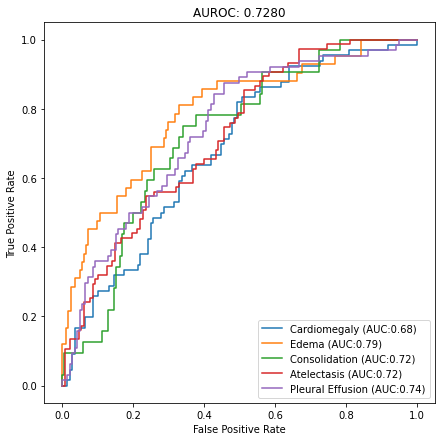

In [8]:
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

fig, ax = plt.subplots(1,1, figsize = (7, 7))

aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), model_predictions[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))

In [5]:
# Se ho un solo modello da valutare, nel caso di Federated e Centralized Model
model = load_model('/content/drive/MyDrive/Models/Centralized/model.h5', compile=None)

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


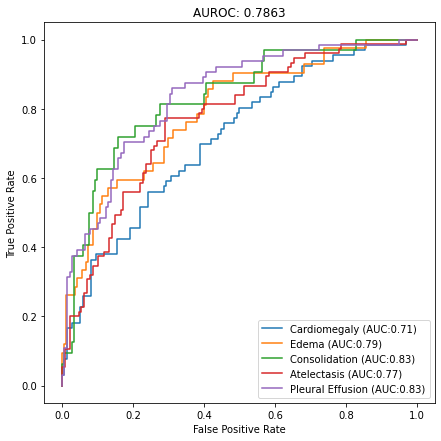

In [6]:
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

fig, ax = plt.subplots(1,1, figsize = (7, 7))

prediction = model.predict(test_dataset)

aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), prediction[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))

# Confusion Matrix

In [9]:
import seaborn as sns
def compute_confusion_matrix(true_labels,predicted_labels):
    tp = 0 
    tn = 0 
    fp = 0 
    fn = 0 
    uncertain = 0 
    for true,predicted in zip(true_labels,predicted_labels):
        if predicted == -1:
            uncertain += 1
        if true == 1 and predicted == 1:
            tp += 1
        if true == 0 and predicted == 0:
            tn += 1
        if true == 0 and predicted == 1:
            fp +=1
        if true == 1 and predicted == 0:
            fn +=1
    return np.array([[tp,fn],[fp,tn]]),uncertain

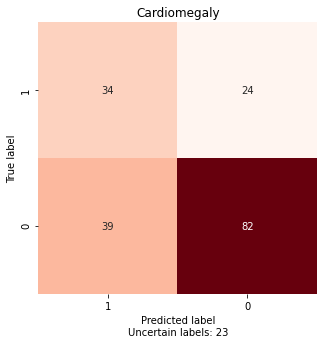

Uncertain labels: 23


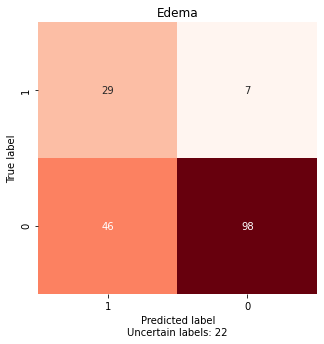

Uncertain labels: 22


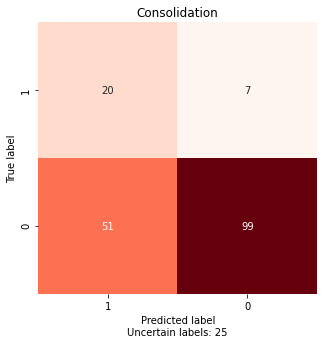

Uncertain labels: 25


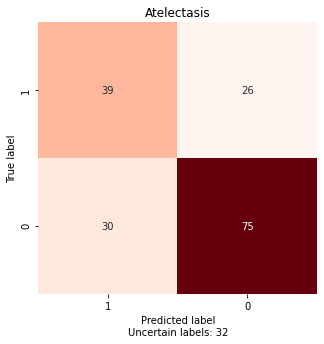

Uncertain labels: 32


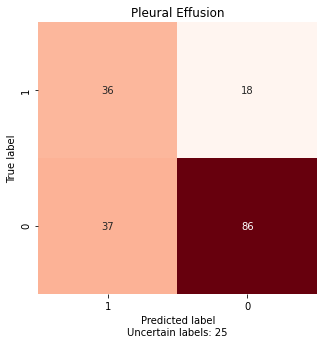

Uncertain labels: 25


In [10]:
#Multiple models (Split and Locals)
thresholds = []
for i in range(len(model_predictions[0])):
    thresholds.append(np.mean(model_predictions[:,i], axis=0))

fin_pred = model_predictions

for i in range(fin_pred.shape[1]):
  threshold = thresholds[i]
  negative_label = (np.logical_and(fin_pred[:,i] >=0, fin_pred[:,i] <threshold-0.10*threshold))
  uncertain = (np.logical_and(fin_pred[:,i]>=threshold-0.10*threshold, fin_pred[:,i]<=threshold+0.10*threshold))
  positive_label = (np.logical_and(fin_pred[:,i]>=threshold+0.10*threshold, fin_pred[:,i]<=1))
  fin_pred[:,i][negative_label] = 0
  fin_pred[:,i][uncertain] = -1
  fin_pred[:,i][positive_label] = 1


  

idxs = [2,5,6,8,10]
label_name = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

for i in idxs:
  cm, uncertain = compute_confusion_matrix(test_Y[:,i],fin_pred[:,i])
  fig = plt.figure(figsize=(5,5))
  sns.heatmap(cm,annot=True,fmt='d',cmap='Reds',cbar = False,yticklabels=[1,0],xticklabels=[1,0])
  plt.ylabel('True label')
  plt.xlabel('Predicted label\nUncertain labels: {}'.format(uncertain))
  plt.title('{}'.format(label_name[i]))
  plt.show()
  spec = cm[1][1] / (cm[1][1] + cm[1][0])
  sensib = cm[0][0] / (cm[0][0] + cm[0][1])
  prec = cm[0][0] / (cm[0][0] + cm[1][0])
  f1 = (2*prec*sensib)/(prec+sensib)
  print('Uncertain labels: {}'.format(uncertain))

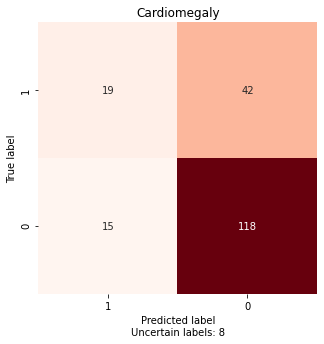

Uncertain labels: 8


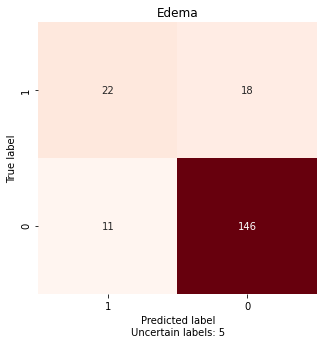

Uncertain labels: 5


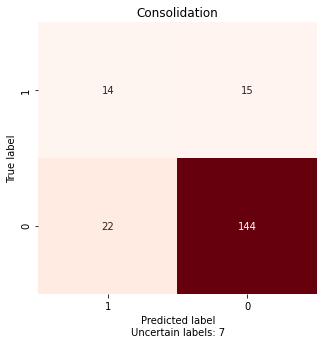

Uncertain labels: 7


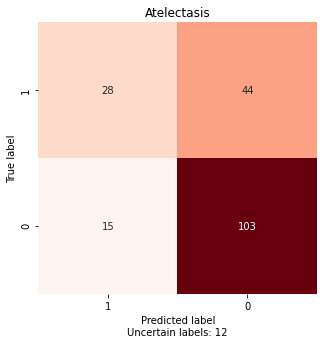

Uncertain labels: 12


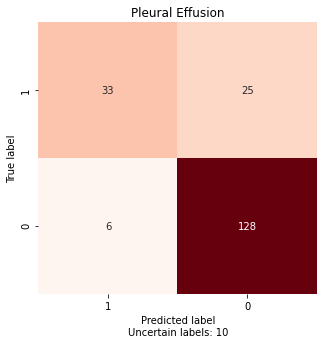

Uncertain labels: 10


In [118]:
#Single model (Federated and Centralized)
thresholds = []
for i in range(len(prediction[0])):
    thresholds.append(np.mean(prediction[:,i], axis=0))

fin_pred = prediction

for i in range(fin_pred.shape[1]):
  threshold = thresholds[i]
  negative_label = (np.logical_and(fin_pred[:,i] >=0, fin_pred[:,i] <threshold-0.10*threshold))
  uncertain = (np.logical_and(fin_pred[:,i]>=threshold-0.10*threshold, fin_pred[:,i]<=threshold+0.10*threshold))
  positive_label = (np.logical_and(fin_pred[:,i]>=threshold+0.10*threshold, fin_pred[:,i]<=1))
  fin_pred[:,i][negative_label] = 0
  fin_pred[:,i][uncertain] = -1
  fin_pred[:,i][positive_label] = 1

idxs = [2,5,6,8,10]
label_name = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

for i in idxs:
  cm, uncertain = compute_confusion_matrix(test_Y[:,i],fin_pred[:,i])
  fig = plt.figure(figsize=(5,5))
  sns.heatmap(cm,annot=True,fmt='d',cmap='Reds',cbar = False,yticklabels=[1,0],xticklabels=[1,0])
  plt.ylabel('True label')
  plt.xlabel('Predicted label\nUncertain labels: {}'.format(uncertain))
  plt.title('{}'.format(label_name[i]))
  plt.show()
  spec = cm[1][1] / (cm[1][1] + cm[1][0])
  sensib = cm[0][0] / (cm[0][0] + cm[0][1])
  prec = cm[0][0] / (cm[0][0] + cm[1][0])
  f1 = (2*prec*sensib)/(prec+sensib)
  print('Uncertain labels: {}'.format(uncertain))